# CellCycleLifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
***

### Imports and utilities

In [10]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
import rootutils
import torch

rootutils.setup_root("./", indicator=".project-root", pythonpath=True)
import torch
from modules.io.load.loaders import GraphLoader
from modules.io.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    plot_manual_graph,
    load_dataset_config,
    load_transform_config,
    load_model_config,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [11]:
dataset_name = "manual_dataset"
dataset_config = load_dataset_config(dataset_name)
dataset = GraphLoader(dataset_config)

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': '/challenge-icml-2024/datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:

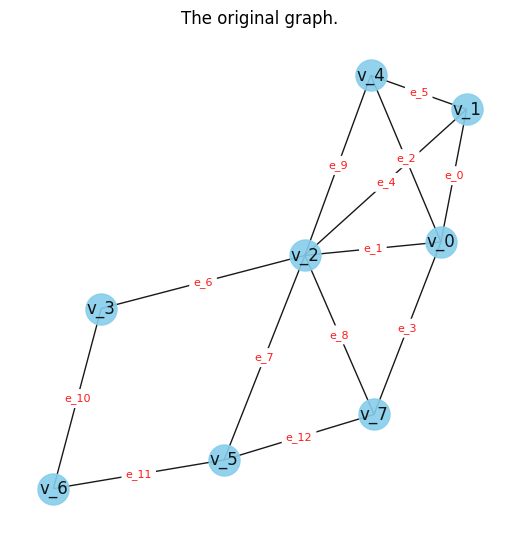

In [12]:
data = dataset.load()
if dataset_name == "manual_dataset":
    plot_manual_graph(data)

In [13]:
print(f"The graph is undirected and has {data.x.shape[0]} nodes and {data.edge_index.shape[1]} edges.")
print(f"The nodes have features have dimension {data.x.shape[1]}.")

connected_nodes = torch.unique(data.edge_index)
isolated_nodes = []
for i in range(data.x.shape[0]):
    if i not in connected_nodes:
        isolated_nodes.append(i)
print(f"There are {len(isolated_nodes)} isolated nodes.")

The graph is undirected and has 8 nodes and 13 edges.
The nodes have features have dimension 1.
There are 0 isolated nodes.


## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data. For this example the cycle lifting was chosen. The algorithm finds a cycle base for the graph and creates a cell for each cycle in said base. This is a connectivity based deterministic lifting that preserves the initial connectivity of the graph.

For cell complexes creating a lifting involves creating a `CellComplex` object from topomodelx and adding cells to it using the method `add_cells_from`. The `CellComplex` class then takes care of creating all the needed matrices.

Similarly to before, we can specify the transformation we want to apply through its type and id --the correxponding config files located at `/configs/transforms`. 

Note that the *tranform_config* dictionary generated below can contain a sequence of tranforms if it is needed.

This can also be used to explore liftings from one topological domain to another, for example using two liftings it is possible to achieve a sequence such as: graph -> cell complex -> hypergraph. 

In [14]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2cell/cycle_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}

{'transform_type': 'lifting',
 'transform_name': 'CellCycleLifting',
 'max_cell_length': None,
 'preserve_edge_attr': False,
 'feature_lifting': 'ProjectionSum'}


We than apply the transform via our `PreProcesor`:

Transform parameters are the same, using existing data_dir: /challenge-icml-2024/datasets/graph/toy_dataset/manual/lifting/1820307683


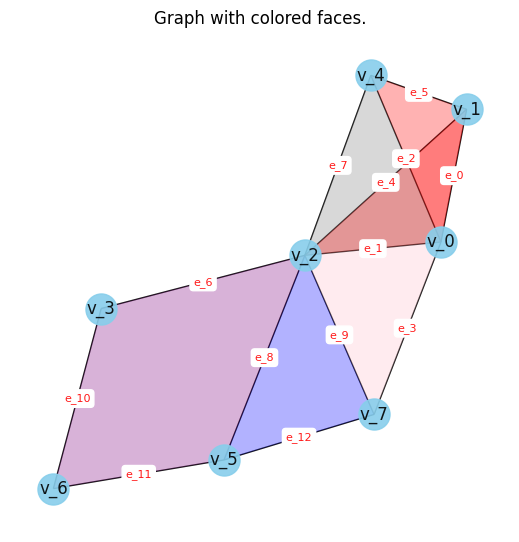

In [15]:
data = PreProcessor(data, transform_config, dataset.data_dir)
if dataset_name == "manual_dataset":
    plot_manual_graph(data)

In [16]:

edges2nodes = [[] for _ in range(data.incidence_1.shape[1])]
indices = data.incidence_1.coalesce().indices()
for i in range(data.incidence_1.shape[1]):
    edges2nodes[i] = indices[0, indices[1,:]==i]
edges2nodes = torch.stack(edges2nodes)

incidence_2 = data.incidence_2.coalesce()
indices = incidence_2.indices()

print(f"The cell complex has {incidence_2.shape[1]} cells.")
for cell_idx in torch.unique(indices[1]):
    corresponding_idxs = indices[1] == cell_idx
    edges = indices[0, corresponding_idxs]
    nodes = torch.unique(edges2nodes[edges])
    print(f"Cell {cell_idx} is composed from the edges {nodes}")
    if cell_idx >= 10:
        print('...')
        break

The cell complex has 6 cells.
Cell 0 is composed from the edges tensor([0, 2, 7])
Cell 1 is composed from the edges tensor([2, 5, 7])
Cell 2 is composed from the edges tensor([2, 3, 5, 6])
Cell 3 is composed from the edges tensor([0, 1, 4])
Cell 4 is composed from the edges tensor([0, 2, 4])
Cell 5 is composed from the edges tensor([0, 1, 2])


## Create and Run a Cell NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `x_0`, `x_1`, `x_2` which are the features of the nodes, edges and cells respectively. It also uses the `adjacency_1`, `incidence_1` and `incidence_2` matrices so the lifting should make sure to add them to the data.

In [17]:
from modules.models.cell.cwn import CWNModel

model_type = "cell"
model_id = "cwn"
model_config = load_model_config(model_type, model_id)

model = CWNModel(model_config, dataset_config)

{'in_channels_0': None,
 'in_channels_1': None,
 'in_channels_2': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2}


In [18]:
y_hat = model(data)

If everything is correct the cell above should execute without errors. 